## Problem 2: Medical Diagnostics

**1. Suppose that the hypothesis space consists of all decision trees with exactly two attribute
splits (repetition along the same path is allowed) for this data set.**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
heart_train = pd.read_csv('heart_train.data', header=None)
heart_test = pd.read_csv('heart_test.data', header=None)

In [3]:
# Changing 0 class to -1 to predict using Sign function
heart_train.loc[heart_train[0] == 0, 0] = -1
heart_test.loc[heart_test[0] == 0, 0] = -1

# Split X, Y
y_train, X_train = heart_train.iloc[:, 0], heart_train.iloc[:, 1:]
y_test, X_test = heart_test.iloc[:, 0], heart_test.iloc[:, 1:]

**(a) Run the adaBoost algorithm for five rounds to train a classifier for this data set. Draw
the 5 selected trees in the order that they occur and report the $\epsilon$ and $\alpha$, generated by
adaBoost, for each.**

In [4]:
attributes = X_train.columns
m, n = X_train.shape
classes = y_train.unique()
T = 5

In [5]:
def generate_2_attr_hypotheses(attributes, classes):
    hypotheses = []
    for l0 in attributes:
        for l1 in attributes:
            for leaf1 in classes:
                for leaf2 in classes:
                    for leaf3 in classes:
                        for attr_val in [0, 1]:
                            toggle = 1 if attr_val == 0 else 0
                            h = {}
                            h[l0] = {}
                            h[l0][attr_val] = leaf1
                            l1_t = {}
                            l1_t[l1] = {}
                            l1_t[l1][toggle] = leaf2
                            l1_t[l1][attr_val] = leaf3
                            h[l0][toggle] = l1_t
                            hypotheses.append(h)
    return hypotheses

H = generate_2_attr_hypotheses(attributes, classes)
assert (len(attributes) ** 2) * 2 * (2**3) == len(H)

In [6]:
def predict(X, h):
    for l0 in h.keys():
        val = X[l0]
        pred = h[l0][val]
        if not isinstance(pred, dict):
            return pred
        else:
            for l1 in pred.keys():
                val = X[l1]
                return pred[l1][val]

def adaboost(H, X_train, y_train):
    m, n = X_train.shape
    w = np.array([1/m] * m)
    alphas = [0] * T
    epsilons = [0] * T
    selected_H = [None] * T
    y_predictions = [None] * T
    print("Running Adaboost")
    for t in range(T):
        e_t = 1
        h_t = None
        y_t = None
        best_i = 0
        h_i = 0
        tq = tqdm(H)
        tq.set_description(f"Round {t+1}")
        for h in tq:
            h_i += 1
            y_pred = X_train.apply(lambda row: predict(row, h), axis=1)
            mask = (y_pred != y_train).astype(np.float64)
            e_h = np.sum(mask * w)
            if e_h < e_t:
                e_t = e_h
                h_t = h
                y_t = y_pred
                best_i = h_i
        print(f"Round {t+1} - Best hypothesis index {best_i}")
        selected_H[t] = h_t
        y_predictions[t] = y_t
        epsilons[t] = e_t
        
        a_t = 0.5 * math.log((1-e_t)/e_t) # Log base e
        alphas[t] = a_t
        
        # Weight update
        normalize = 2 * np.sqrt(e_t * (1-e_t))
        w = w * np.exp(-1 * y_train * y_t * a_t)/normalize
    return np.array(alphas), np.array(epsilons), selected_H, np.array(y_predictions)

In [7]:
a, e, h_, y_ = adaboost(H, X_train, y_train)

Running Adaboost



Round 1 - Best hypothesis index 3718



Round 2 - Best hypothesis index 1398



Round 3 - Best hypothesis index 1011



Round 4 - Best hypothesis index 2710



Round 5 - Best hypothesis index 1011


In [8]:
def boosting_predict(a, H=None, x=None, h_x=None):
    if h_x is None:
        h_x = []
        for h in H:
            y_pred = x.apply(lambda row: predict(row, h), axis=1)
            h_x.append(y_pred)
        h_x = np.array(h_x)
    return np.sign(a.dot(h_x))

def accuracy(y_truth, y_pred):
    return np.mean(y_truth == y_pred)

In [9]:
print("Alphas", a)

Alphas [0.65496069 0.3784315  0.27349727 0.40631556 0.28568171]


In [10]:
print("Epsilons", e)

Epsilons [0.2125     0.31932773 0.36656198 0.3073301  0.36092228]


In [11]:
print("Hypotheses")
def pretty_print_h(h):
    for l0 in h.keys():
        print(l0)
        l1 = h[l0]
        for l2 in l1.keys():
            print('\t',l2)
            print('\t\t', l1[l2])
for h in h_:
    pretty_print_h(h)

Hypotheses
11
	 1
		 1
	 0
		 {13: {0: -1, 1: 1}}
4
	 1
		 1
	 0
		 {22: {0: -1, 1: 1}}
3
	 0
		 1
	 1
		 {20: {1: 1, 0: -1}}
8
	 1
		 1
	 0
		 {16: {0: -1, 1: 1}}
3
	 0
		 1
	 1
		 {20: {1: 1, 0: -1}}


**(b) Run the adaBoost algorithm for 10 rounds of boosting. Plot the accuracy on the training
and test sets versus iteration number.**

In [12]:
T = 10
a, e, h_, y_ = adaboost(H, X_train, y_train)

In [15]:
iterations = []
train_accuracies = []
test_accuracies = []

for t in range(T):
    iterations.append(t+1)
        
    pred = boosting_predict(np.array(a[:t+1]), h_x=y_[:t+1])
    train_accuracies.append(accuracy(y_train.ravel(), pred.flatten()))
            
    pred = boosting_predict(np.array(a[:t+1]), H=h_[:t+1], x=X_test)
    test_accuracies.append(accuracy(y_test.ravel(), pred.flatten()))

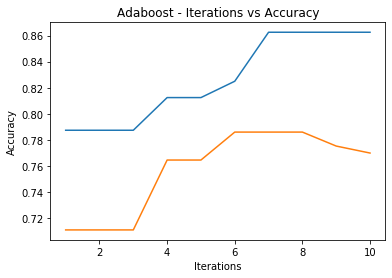

In [16]:
plt.plot(iterations, train_accuracies, label='Train accuracies')
plt.plot(iterations, test_accuracies, label='Test accuracies')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Adaboost - Iterations vs Accuracy')
plt.show()